In [37]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.set_floatx('float64')

### Define the network

In [38]:
H = 10

model3 = keras.Sequential([
    layers.Dense(units = H, activation = 'sigmoid', input_shape = (1,)),
    layers.Dense(units = 1, activation = 'linear', use_bias = False)
])

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 10)                20        
                                                                 
 dense_11 (Dense)            (None, 1)                 10        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


### Define grid points to use as input data

In [39]:
a = 0
b = 1
N = 8
h = (b - a)/(N + 1)

#Grid points:
x = []
for i in range(N + 2):
    x.append(a + i*h)
input_data = np.array(x)
input_data = input_data.reshape(10,1)

### Training routine

In [40]:
def trainStep(x,opt):
    
    # Outer GradientTape for derivatives wrt model parameters
    with tf.GradientTape() as tape:
        
        # Middle GradientTape for first derivative of N wrt x
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            
            # Inner GradientTape for second derivative of N wrt x
            with tf.GradientTape() as tape2:
                tape2.watch(x)
            
                N = model3([x])
            
            Nx = tape2.gradient(N, x)
        Nxx = tape1.gradient(Nx, x)
        
        # Plug trial solution into ODE:
        eqn = (-2*N + 2*(1-2*x)*Nx + x*(1-x)*Nxx + 
        0.2*(np.sin(1)*np.exp(-0.2) + (1-2*x)*N+x*(1-x)*Nx) + 
        x*np.sin(1)*np.exp(-0.2) + x*(1-x)*N + 0.2*np.exp(-x/5)*np.cos(x))
        
        loss = tf.reduce_sum(tf.square(eqn))
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model3.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model3.trainable_variables))
    
    return loss

In [41]:
def PINNtrain(x, epochs):
    
    # Define an optimizer
    lr = tf.keras.optimizers.schedules.PolynomialDecay(0.1, epochs, 1e-4)
    opt = keras.optimizers.Adam(lr)
    epoch_loss = np.zeros(epochs)
    
    input_data = np.column_stack([x]).astype(np.float64)
    
    batch_size = 5
    data_sample = tf.data.Dataset.from_tensor_slices(input_data)
    data_sample = data_sample.cache().shuffle(10).batch(batch_size)
    
    ds = tf.data.Dataset.zip((data_sample))
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    # Main training loop
    for i in range(epochs):
        
        for j in ds:
            
            PDEloss = trainStep(j,opt)
            epoch_loss[i] += PDEloss

        if np.mod(i, 100)==0 or i == 9999:
          print("PDE loss in {}th epoch: {: 1.4e}.".format(i, epoch_loss[i]))
    
    return epoch_loss

In [42]:
epochs = 10000
loss = PINNtrain(input_data,epochs)

PDE loss in 0th epoch:  7.2991e+00.
PDE loss in 100th epoch:  1.1269e-04.
PDE loss in 200th epoch:  9.0351e-06.
PDE loss in 300th epoch:  1.0495e-05.
PDE loss in 400th epoch:  6.6493e-06.
PDE loss in 500th epoch:  1.0758e-05.
PDE loss in 600th epoch:  8.6979e-06.
PDE loss in 700th epoch:  6.3566e-06.
PDE loss in 800th epoch:  4.1598e-05.
PDE loss in 900th epoch:  3.5982e-05.
PDE loss in 1000th epoch:  1.3596e-05.
PDE loss in 1100th epoch:  1.7318e-05.
PDE loss in 1200th epoch:  1.5454e-02.
PDE loss in 1300th epoch:  2.7185e-02.
PDE loss in 1400th epoch:  7.6185e-04.
PDE loss in 1500th epoch:  1.4434e-04.
PDE loss in 1600th epoch:  3.3013e-04.
PDE loss in 1700th epoch:  3.3990e-05.
PDE loss in 1800th epoch:  2.5286e-05.
PDE loss in 1900th epoch:  5.7905e-05.
PDE loss in 2000th epoch:  4.4104e-04.
PDE loss in 2100th epoch:  1.0066e-03.
PDE loss in 2200th epoch:  5.6564e-05.
PDE loss in 2300th epoch:  1.2533e-04.
PDE loss in 2400th epoch:  3.2895e-04.
PDE loss in 2500th epoch:  1.0288e-05

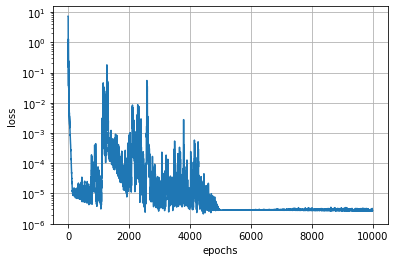

In [43]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')

plt.grid()
plt.show()

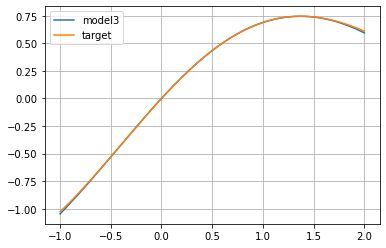

In [47]:
x = np.linspace(-1,2,300)
target = []

for i in range(300): 
    target.append(np.exp(-x[i]/5)*np.sin(x[i])) 
    
plt.plot(x,x*np.sin(1)*np.exp(-1/5) + x*(1-x)*model3([x]).numpy().T[0], label = 'model3')
plt.plot(x,target, label = 'target')
plt.legend(loc =  'upper left')
plt.grid()
plt.show()

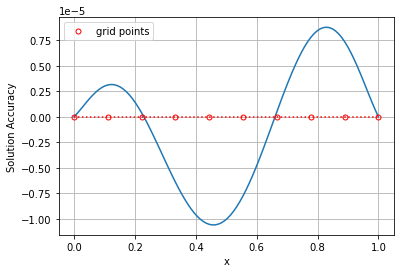

In [48]:
grid_points = np.linspace(0,1,10)
x = np.linspace(0,1,100)
target = []

for i in range(100): 
    target.append(np.exp(-x[i]/5)*np.sin(x[i])) 

plt.plot(x,target-(x*np.sin(1)*np.exp(-1/5) + x*(1-x)*model3([x]).numpy().T[0]))
plt.plot(x,[0]*100, ':r')
plt.plot(grid_points,[0]*10, 'o', color = 'red', mfc = 'none', markersize = 5, label = 'grid points')
plt.ylabel('Solution Accuracy')
plt.xlabel('x')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()